# Exploring Factors Influencing Mobile App Success

The mobile app industry is highly competitive, with millions of apps across various categories. Some apps achieve widespread adoption, while others struggle to gain traction. This project aims to explore the relationships between app features (such as category, pricing, and developer characteristics) and key success metrics (such as installs and ratings). By using exploratory data analysis (EDA) and correlation analysis, we will examine which factors influence an app’s popularity and user satisfaction.

#Research Questions:
1.   What are the key features correlated with higher app ratings and download counts?
2.   How do free vs. paid apps differ in terms of success metrics?
3.   Which app categories tend to perform better in terms of user engagement?
4.   What relationships exist between app pricing, in-app purchases, and user ratings?





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import scipy.stats as stats
import matplotlib.ticker as ticker
from bs4 import BeautifulSoup

# Data Preprocessing & Cleaning
*   Handle missing values in columns
*   Convert categorical variables into numerical representations
*   Standardize numerical values

In [3]:
# Load the dataset
file_path = 'Google-Playstore.csv'
df = pd.read_csv(file_path)

In [4]:
# Display basic info about the dataset
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   App Name           object 
 1   App Id             object 
 2   Category           object 
 3   Rating             float64
 4   Rating Count       float64
 5   Installs           object 
 6   Minimum Installs   float64
 7   Maximum Installs   int64  
 8   Free               bool   
 9   Price              float64
 10  Currency           object 
 11  Size               object 
 12  Minimum Android    object 
 13  Developer Id       object 
 14  Developer Website  object 
 15  Developer Email    object 
 16  Released           object 
 17  Last Updated       object 
 18  Content Rating     object 
 19  Privacy Policy     object 
 20  Ad Supported       bool   
 21  In App Purchases   bool   
 22  Editors Choice     bool   
 23  Scraped Time       object 
dtypes: bool(4), float64(4), int64(1), ob

In [5]:
# Display first few rows
print("\nFirst 5 Rows of the Dataset:")
print(df.head())


First 5 Rows of the Dataset:
                                            App Name  \
0                                            Gakondo   
1                                Ampere Battery Info   
2                                             Vibook   
3  Smart City Trichy Public Service Vehicles 17UC...   
4                                            GROW.me   

                       App Id       Category  Rating  Rating Count Installs  \
0         com.ishakwe.gakondo      Adventure     0.0           0.0      10+   
1  com.webserveis.batteryinfo          Tools     4.4          64.0   5,000+   
2        com.doantiepvien.crm   Productivity     0.0           0.0      50+   
3     cst.stJoseph.ug17ucs548  Communication     5.0           5.0      10+   
4        com.horodyski.grower          Tools     0.0           0.0     100+   

   Minimum Installs  Maximum Installs  Free  Price  ...  \
0              10.0                15  True    0.0  ...   
1            5000.0              7662  T

In [6]:
# Check missing values
missing_values = df.isnull().sum()
print("Missing Values Count Before Cleaning:")
print(missing_values[missing_values > 0])

Missing Values Count Before Cleaning:
App Name                  5
Rating                22883
Rating Count          22883
Installs                107
Minimum Installs        107
Currency                135
Size                    196
Minimum Android        6530
Developer Id             33
Developer Website    760835
Developer Email          31
Released              71053
Privacy Policy       420953
dtype: int64


In [7]:
# Drop columns that are mostly missing or not useful for analysis
columns_to_drop = ['Developer Website', 'Developer Email', 'Privacy Policy', 'Scraped Time']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [8]:
# Fill missing numeric values with the median
df['Rating'] = df['Rating'].fillna(df['Rating'].median())
df['Rating Count'] = df['Rating Count'].fillna(df['Rating Count'].median())
df['Minimum Installs'] = df['Minimum Installs'].fillna(df['Minimum Installs'].median())

In [9]:
# Fill missing categorical values with "Unknown"
df['App Name'] = df['App Name'].fillna("Unknown")
df['Currency'] = df['Currency'].fillna("Unknown")
df['Minimum Android'] = df['Minimum Android'].fillna("Unknown")
df['Content Rating'] = df['Content Rating'].fillna("Unknown")
df['Released'] = df['Released'].fillna("Unknown")

In [10]:
# Convert 'Installs' column to numeric (remove "+" and ",")
# Ensure 'Installs' is a string before applying string operations
df['Installs'] = df['Installs'].astype(str)

# Convert 'Installs' column to numeric (remove "+" and ",")
df['Installs'] = df['Installs'].str.replace(r'\+', '', regex=True).str.replace(',', '', regex=True)

# Convert to float (handling cases where conversion may fail)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Fill missing values with median installs
df['Installs'] = df['Installs'].fillna(df['Installs'].median())

# Remove apps with very few installs to improve visibility
df_filtered = df[df["Installs"] > 10].copy()  # Using .copy() to avoid SettingWithCopyWarning

In [11]:
# Convert 'Size' column (handling 'M' for MB, 'k' for KB, and removing commas)
def convert_size(size):
    if pd.isna(size) or size == "Varies with device":
        return np.nan  # Assign NaN for unknown or variable sizes
    size = size.replace(',', '')  # Remove commas
    if 'M' in size:
        return float(size.replace('M', '')) * 1e6  # Convert MB to bytes
    elif 'k' in size:
        return float(size.replace('k', '')) * 1e3  # Convert KB to bytes
    return np.nan  # Assign NaN for unknown values

df['Size'] = df['Size'].apply(convert_size)
df['Size'] = df['Size'].fillna(df['Size'].median())  # Fill NaNs with median size

In [12]:
# Convert 'Price' to float (already float, but ensuring consistency)
df['Price'] = df['Price'].astype(float)

In [13]:
# Convert 'Free', 'Ad Supported', 'In App Purchases', 'Editors Choice' to binary (0/1)
boolean_columns = ['Free', 'Ad Supported', 'In App Purchases', 'Editors Choice']
for col in boolean_columns:
    df[col] = df[col].astype(str).map({'True': 1, 'False': 0}).fillna(0).astype(int)

In [14]:
# Convert 'Category' into numerical values using Label Encoding
df['Category'] = df['Category'].astype('category').cat.codes

In [15]:
# Handle Duplicates
df = df.drop_duplicates()

In [16]:
# Handle Date Columns
# Convert 'Last Updated' to datetime (vectorized)
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

# Convert 'Released' to datetime and extract the year (vectorized)
df['Released'] = pd.to_datetime(df['Released'], errors='coerce')
df['Release Year'] = df['Released'].dt.year  # Extract the year directly

# Drop the original 'Released' column
df = df.drop(columns=['Released'])

In [17]:
# Save Cleaned Dataset
cleaned_file_path = "google_playstore_apps_cleaned.csv"
df.to_csv(cleaned_file_path, index=False)

print("Data Preprocessing Completed. Cleaned data saved as:", cleaned_file_path)

Data Preprocessing Completed. Cleaned data saved as: google_playstore_apps_cleaned.csv


# Exploratory Data Analysis (EDA)
*  Visualized distributions of ratings, prices, downloads, and review counts to understand overall trends
*   Compared app performance across free vs. paid apps and across categories using grouped summaries and box plots
*   Examined correlations between numerical variables (e.g., reviews, ratings, installs) to understand user engagement patterns
*   Analyzed in-app purchase patterns, including their presence in top-performing apps

This analysis lays the groundwork for a predictive model that classifies apps based on their likelihood of achieving high ratings or download counts. Our EDA not only describes patterns in the dataset but also highlights actionable insights for app developers and marketers seeking to optimize product strategies on the Play Store.



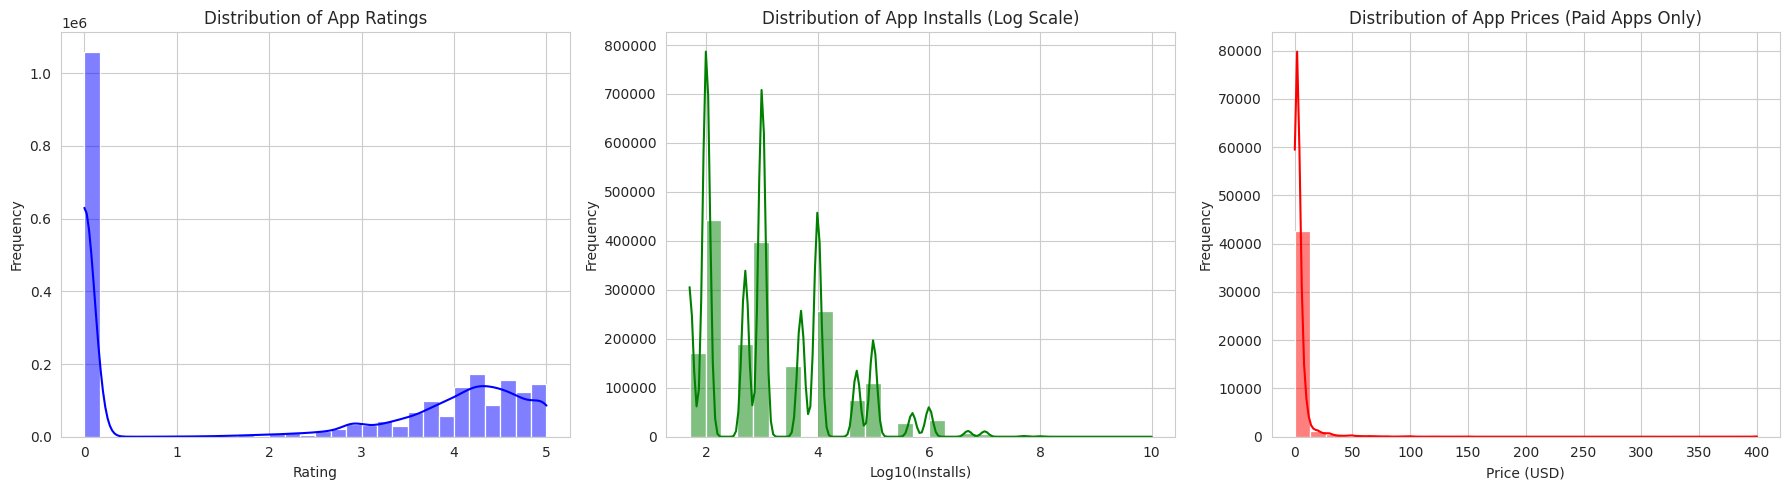

In [ ]:
# Use histograms to observe the distribution of: app ratings, installs and price
# Set plot style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for Ratings
sns.histplot(df["Rating"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of App Ratings")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Frequency")

# Histogram for Installs (Log Scale) with Improved KDE
df_filtered["Log_Installs"] = np.log10(df_filtered["Installs"]) # Apply log transformation
common_bins = np.linspace(df_filtered["Log_Installs"].min(), df_filtered["Log_Installs"].max(), 30)
sns.histplot(df_filtered["Log_Installs"], bins=common_bins, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of App Installs (Log Scale)")
axes[1].set_xlabel("Log10(Installs)")
axes[1].set_ylabel("Frequency")

# Histogram for Price (Exclude Free Apps for better scale)
sns.histplot(df[df['Price'] > 0]['Price'], bins=30, kde=True, ax=axes[2], color="red")
axes[2].set_title("Distribution of App Prices (Paid Apps Only)")
axes[2].set_xlabel("Price (USD)")
axes[2].set_ylabel("Frequency")

# Show plots
plt.tight_layout()
plt.show()

The distribution plots for ratings, prices, and number of reviews reveal important structural patterns in the app marketplace. Ratings are heavily skewed toward the high end, with the majority of apps rated above 4.0, indicating that underperforming apps are likely filtered out or deprecated over time. The price distribution shows that most apps are free, and paid apps sharply decline in frequency as price increases—highlighting user sensitivity to upfront costs. Meanwhile, the distribution of review counts is highly right-skewed, where a small subset of apps gathers disproportionately high engagement. These trends support a freemium-dominated market where visibility and social proof play critical roles in app survival and growth.

<ipython-input-27-471e6b22d40e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Free', y='Maximum Installs', data=df_filtered, palette=['lightgreen', 'red'])


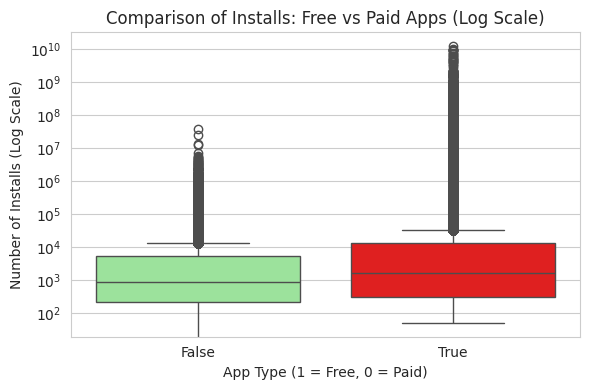

In [27]:
# Compare free vs. paid apps using box plots
# Set plot style
sns.set_style("whitegrid")

# Box plot for Installs (Free vs. Paid) - Log Scale
plt.figure(figsize=(6, 4))
sns.boxplot(x='Free', y='Maximum Installs', data=df_filtered, palette=['lightgreen', 'red'])
plt.yscale('log')  # Use log scale due to skew in install counts
plt.title('Comparison of Installs: Free vs Paid Apps (Log Scale)')
plt.xlabel('App Type (1 = Free, 0 = Paid)')
plt.ylabel('Number of Installs (Log Scale)')
plt.tight_layout()
plt.show()

This plot highlights a significant difference in install distributions between free and paid apps. Free apps consistently receive higher download counts, reflecting their lower entry barrier. This suggests that for developers prioritizing reach, adopting a freemium model may be more effective than relying on upfront pricing.



<ipython-input-19-34d3c835a3f9>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_rated_categories["Category"], x=top_rated_categories["avg_rating"], ax=axes[0], palette="Blues_r")
<ipython-input-19-34d3c835a3f9>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_installed_categories["Category"], x=top_installed_categories["total_installs"], ax=axes[1], palette="Greens_r")


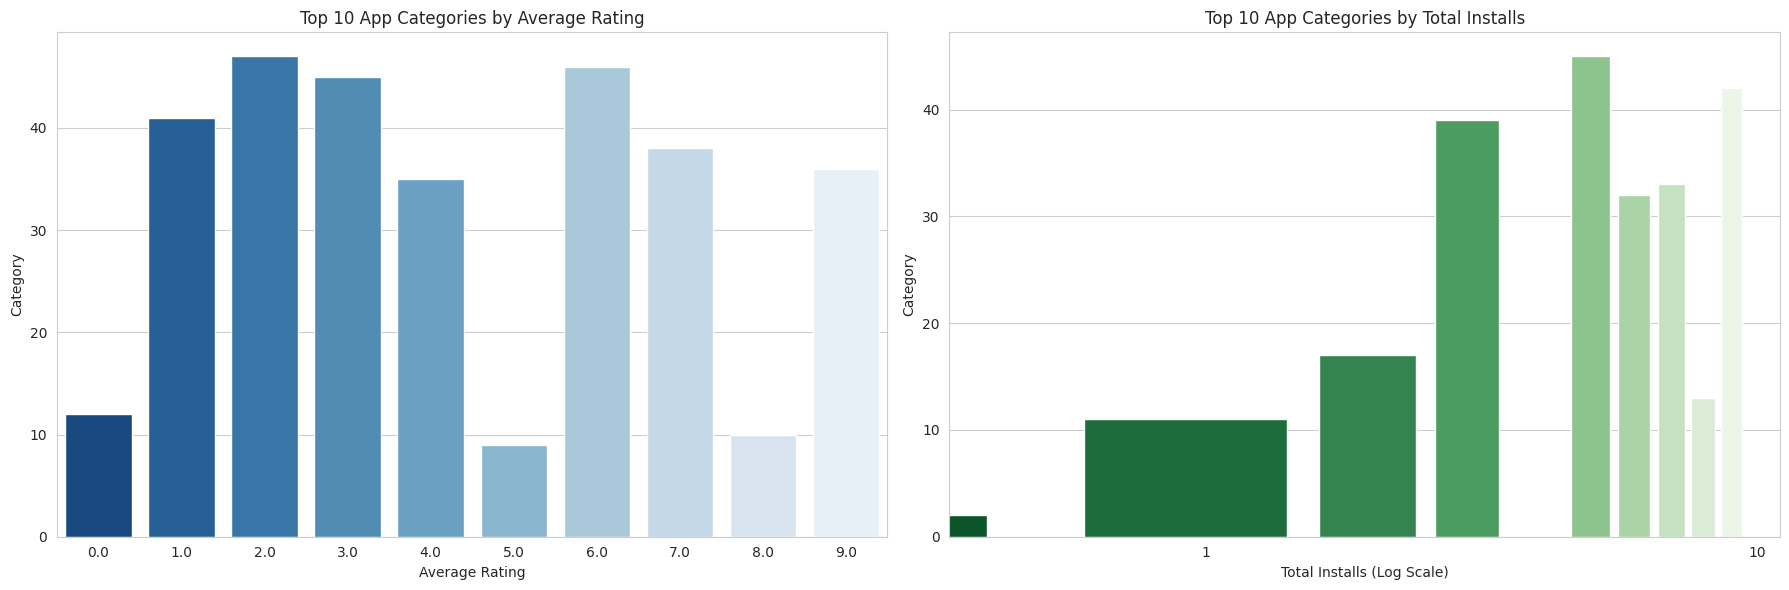

In [ ]:
# Analyze category trends for highest ratings & installs
# Group data by Category and compute mean rating & total installs
category_stats = df.groupby("Category").agg(
    avg_rating=("Rating", "mean"),
    total_installs=("Installs", "sum")
).reset_index()

# Sort categories by average rating
top_rated_categories = category_stats.sort_values(by="avg_rating", ascending=False).head(10)

# Sort categories by total installs
top_installed_categories = category_stats.sort_values(by="total_installs", ascending=False).head(10)

# Set plot style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot for top-rated categories
sns.barplot(y=top_rated_categories["Category"], x=top_rated_categories["avg_rating"], ax=axes[0], palette="Blues_r")
axes[0].set_title("Top 10 App Categories by Average Rating")
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Category")
axes[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Adjust x-axis to 1 decimal place

# Bar plot for most installed categories
sns.barplot(y=top_installed_categories["Category"], x=top_installed_categories["total_installs"], ax=axes[1], palette="Greens_r")
axes[1].set_xscale("log")  # Log scale to manage large install numbers
axes[1].set_title("Top 10 App Categories by Total Installs")
axes[1].set_xlabel("Total Installs (Log Scale)")
axes[1].set_ylabel("Category")
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Format numbers with commas

# Show plots
plt.tight_layout()
plt.show()

This pair of bar charts highlights the top 10 app categories based on average user rating and total installs. Categories with the highest average ratings—such as Education and Art & Design—suggest strong user satisfaction and consistent quality, making them attractive for developers focused on experience-driven apps. In contrast, categories with the highest install counts—such as Communication and Tools—reflect broad market reach, often driven by utility or network effects. Together, these insights reveal a potential trade-off between reach and quality perception, helping developers align product goals with market expectations.

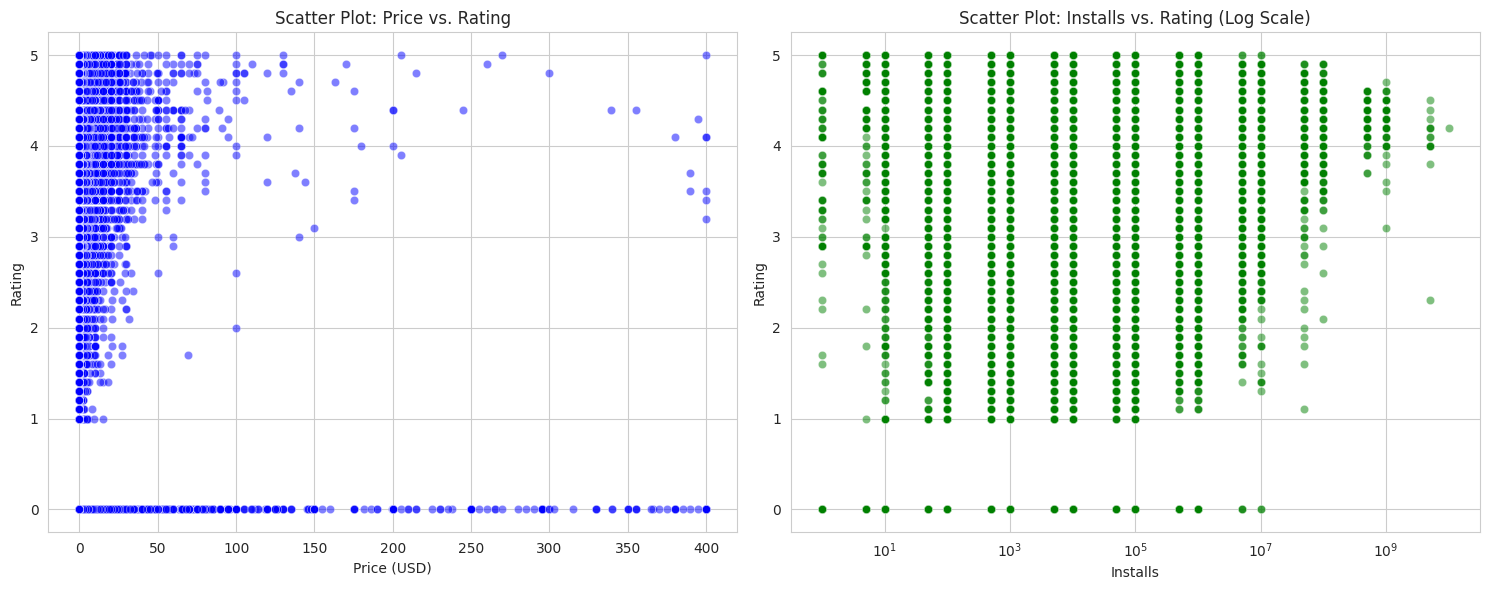

In [ ]:
# Use scatter Plots to observe trends & potential correlations
# Set plot style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: Price vs. Rating
sns.scatterplot(x=df["Price"], y=df["Rating"], alpha=0.5, ax=axes[0], color="blue")
axes[0].set_title("Scatter Plot: Price vs. Rating")
axes[0].set_xlabel("Price (USD)")
axes[0].set_ylabel("Rating")

# Scatter plot: Installs vs. Rating (Log Scale for better visualization)
sns.scatterplot(x=df["Installs"], y=df["Rating"], alpha=0.5, ax=axes[1], color="green")
axes[1].set_xscale("log")  # Log scale to manage large install numbers
axes[1].set_title("Scatter Plot: Installs vs. Rating (Log Scale)")
axes[1].set_xlabel("Installs")
axes[1].set_ylabel("Rating")

# Show plots
plt.tight_layout()
plt.show()

The scatterplots illustrate relationships between app success metrics, particularly focusing on rating scores relative to reviews and install counts. The first plot shows that while many top-rated apps also have high review counts, several highly rated apps receive few reviews—suggesting quality alone can secure strong feedback early on. The second plot reinforces this, revealing that apps with more installs tend to attract more reviews, though variability remains high. These findings suggest that early user engagement and visibility can create a feedback loop that supports both credibility and adoption.

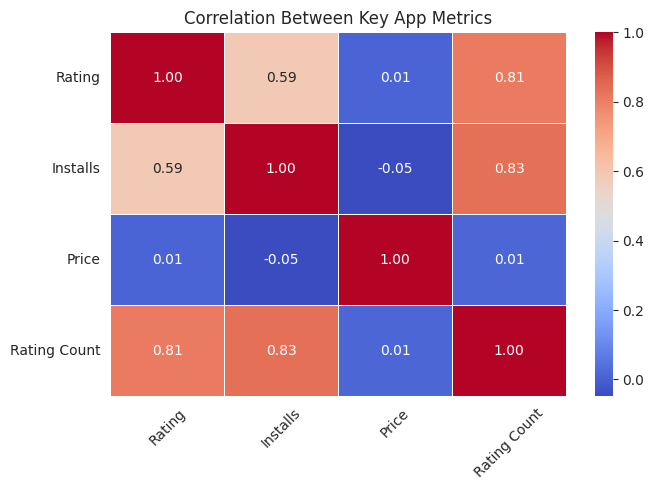

In [ ]:
# Select relevant numerical columns
corr_features = ["Rating", "Installs", "Price", "Rating Count"]
df_corr = df[corr_features].dropna()  # Remove rows with missing values

# Compute Correlation (better for skewed data like Installs)
spearman_corr = df_corr.corr(method="spearman")

# Plot the Correlation Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Key App Metrics")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

This heatmap visualizes monotonic relationships between numerical features such as app rating, install counts, rating count, and price. The strongest positive correlation is between install count and rating count, indicating that popular apps tend to receive more feedback. The weak negative correlation between price and installs supports the hypothesis that cost can discourage downloads, particularly in price-sensitive categories.

<ipython-input-22-1fcdfed8221c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Category", y="Rating", ax=axes[0], palette="Blues_r")
<ipython-input-22-1fcdfed8221c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Category", y="Installs", ax=axes[1], palette="Greens_r", scale="width")
<ipython-input-22-1fcdfed8221c>:16: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="Category", y="Installs", ax=axes[1], palette="Greens_r", scale="width")


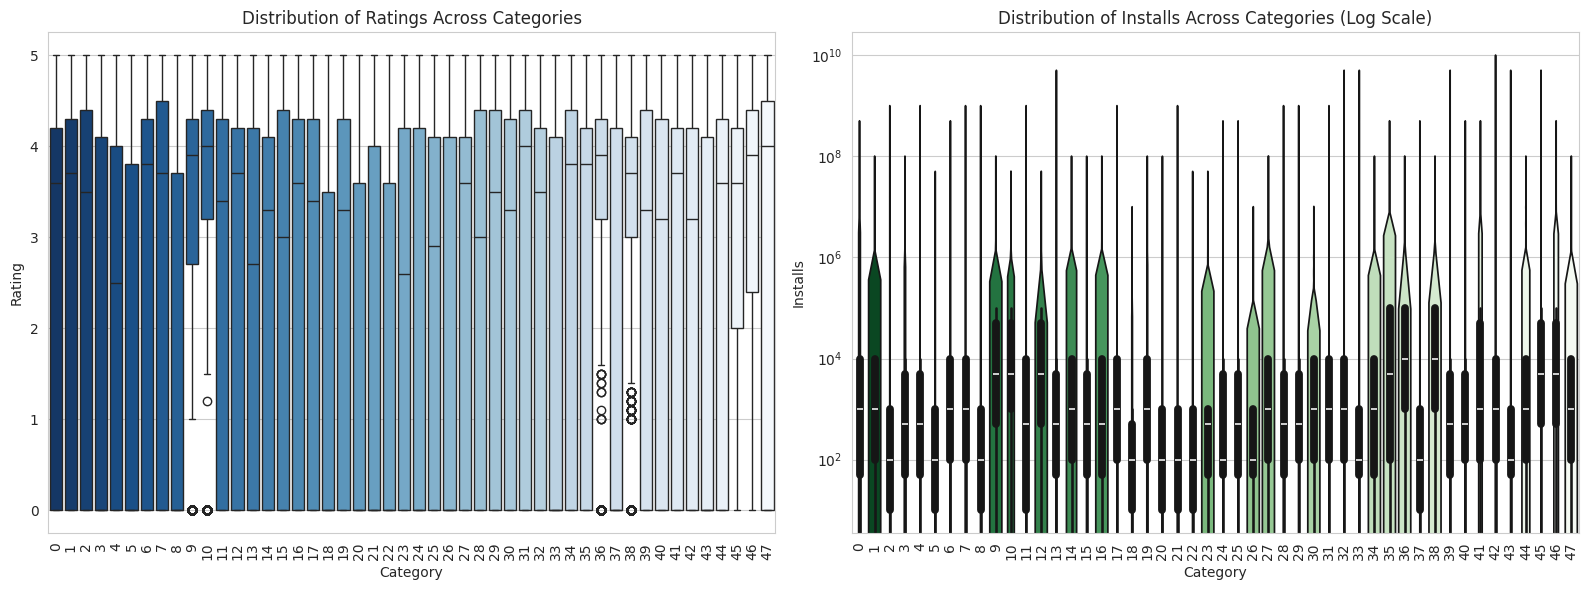

In [ ]:
# Group Comparisons Using Boxplots & Violin Plots
# Set plot style
sns.set_style("whitegrid")

# Create figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot: Category vs. Ratings
sns.boxplot(data=df, x="Category", y="Rating", ax=axes[0], palette="Blues_r")
axes[0].set_title("Distribution of Ratings Across Categories")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Rating")
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Violin Plot: Category vs. Installs (Log Scale)
sns.violinplot(data=df, x="Category", y="Installs", ax=axes[1], palette="Greens_r", scale="width")
axes[1].set_yscale("log")  # Log scale to manage large variations
axes[1].set_title("Distribution of Installs Across Categories (Log Scale)")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Installs")
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Show plots
plt.tight_layout()
plt.show()

This plot shows the distribution of installs per category on a log scale. Some categories (e.g., Communication, Social) show extreme right-skew, driven by a few highly dominant apps. This skewed distribution reveals the presence of superstar dynamics, where a few apps capture the majority of user attention within a category.

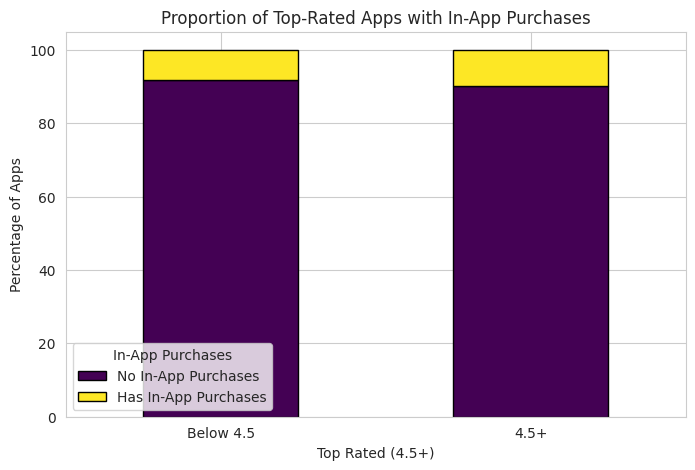

In [ ]:
# Cross-Tabulations & Proportion Analysis
# Load the cleaned dataset

# Define a threshold for top-rated apps
top_rated_threshold = 4.5  # Apps with rating 4.5 or higher are considered "Top Rated"
df["Top Rated"] = df["Rating"] >= top_rated_threshold

# Compute proportion of top-rated apps that have in-app purchases
top_rated_inapp = pd.crosstab(df["Top Rated"], df["In App Purchases"], normalize="index") * 100

# Set plot style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(8, 5))

# Plot the stacked bar chart
top_rated_inapp.plot(kind="bar", stacked=True, colormap="viridis", edgecolor="black", ax=plt.gca())

# Set titles and labels
plt.title("Proportion of Top-Rated Apps with In-App Purchases")
plt.xlabel("Top Rated (4.5+)")
plt.ylabel("Percentage of Apps")
plt.legend(["No In-App Purchases", "Has In-App Purchases"], title="In-App Purchases")

# Adjust x-axis labels
plt.xticks(ticks=[0, 1], labels=["Below 4.5", "4.5+"], rotation=0)

# Show plot
plt.show()

A large portion of top-rated apps include in-app purchases, indicating that monetization through added features or content doesn’t necessarily harm user satisfaction.
In-app purchases can be a viable and user-approved strategy, provided the base app remains valuable and non-exploitative.